In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report
import numpy as np
from tqdm import tqdm

In [3]:
tqdm.pandas()
df = pd.read_csv("./yelp_reviews.csv")
df

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15
...,...,...,...,...,...,...,...,...,...
6990275,H0RIamZu0B0Ei0P4aeh3sQ,qskILQ3k0I_qcCMI-k6_QQ,jals67o91gcrD4DC81Vk6w,5.0,1,2,1,Latest addition to services from ICCU is Apple...,2014-12-17 21:45:20
6990276,shTPgbgdwTHSuU67mGCmZQ,Zo0th2m8Ez4gLSbHftiQvg,2vLksaMmSEcGbjI5gywpZA,5.0,2,1,2,"This spot offers a great, affordable east week...",2021-03-31 16:55:10
6990277,YNfNhgZlaaCO5Q_YJR4rEw,mm6E4FbCMwJmb7kPDZ5v2Q,R1khUUxidqfaJmcpmGd4aw,4.0,1,0,0,This Home Depot won me over when I needed to g...,2019-12-30 03:56:30
6990278,i-I4ZOhoX70Nw5H0FwrQUA,YwAMC-jvZ1fvEUum6QkEkw,Rr9kKArrMhSLVE9a53q-aA,5.0,1,0,0,For when I'm feeling like ignoring my calorie-...,2022-01-19 18:59:27


In [4]:
# Ignore 3 star reviews for neutral sentiments
df = df[df['stars'] != 3]
df['label'] = (df['stars'] >= 4).astype(int)
df.drop(columns='stars', inplace=True)

#Split of 80/10/10 for train, val and test
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
n_total = len(df)
n_train = int(0.8 * n_total)
n_val = int(0.1 * n_total)

df_train = df.iloc[:n_train]
df_val = df.iloc[n_train:n_train + n_val]
df_test = df.iloc[n_train + n_val:]

print("Vectorizing text with TfidfVectorizer...")

#Initialization of TfidVectorizer for reviews
vectorizer = TfidfVectorizer(
    stop_words='english',
    lowercase=True
)

# X, y text and labels transform process with vectorizer 
X_train = vectorizer.fit_transform(tqdm(df_train['text'], desc="Fitting TF-IDF"))
X_val = vectorizer.transform(tqdm(df_val['text'], desc="Transforming validation"))
X_test = vectorizer.transform(tqdm(df_test['text'], desc="Transforming test"))

y_train = df_train['label'].values
y_val = df_val['label'].values
y_test = df_test['label'].values

# Train model with verbose output
print("Training LogisticRegressionCV...")

clf = LogisticRegressionCV(
    Cs=[0.01, 0.05, 0.1, 1.0], #Testing different C regularization parameters
    cv=3,
    scoring='accuracy',
    max_iter=1000,
    n_jobs=-1,
    verbose=1  # Print training progress
)
clf.fit(X_train, y_train)

# Evaluation review
print("\nValidation Performance:\n", classification_report(y_val, clf.predict(X_val)))
print("Test Performance:\n", classification_report(y_test, clf.predict(X_test)))

C:\Users\krush\AppData\Local\Temp\ipykernel_24176\4081674991.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = (df['stars'] >= 4).astype(int)
C:\Users\krush\AppData\Local\Temp\ipykernel_24176\4081674991.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns='stars', inplace=True)


Vectorizing text with TfidfVectorizer...


Transforming test: 100%|██████████| 629836/629836 [00:19<00:00, 31648.43it/s]


Training LogisticRegressionCV...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.8min finished



Validation Performance:
               precision    recall  f1-score   support

           0       0.93      0.88      0.91    162002
           1       0.96      0.98      0.97    467832

    accuracy                           0.95    629834
   macro avg       0.95      0.93      0.94    629834
weighted avg       0.95      0.95      0.95    629834

Test Performance:
               precision    recall  f1-score   support

           0       0.93      0.88      0.91    161384
           1       0.96      0.98      0.97    468452

    accuracy                           0.95    629836
   macro avg       0.95      0.93      0.94    629836
weighted avg       0.95      0.95      0.95    629836



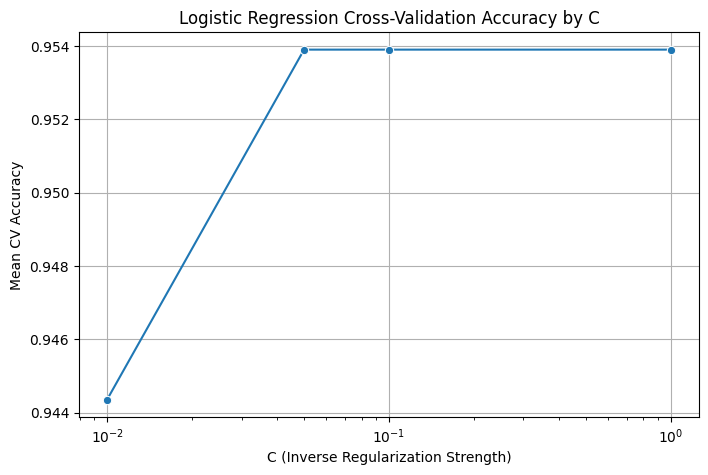

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Plot mean cross-validation accuracy for each C
mean_scores = clf.scores_[1].mean(axis=0)
C_values = clf.Cs_

plt.figure(figsize=(8, 5))
sns.lineplot(x=C_values, y=mean_scores, marker='o')
plt.xscale('log')
plt.xlabel("C (Inverse Regularization Strength)")
plt.ylabel("Mean CV Accuracy")
plt.title("Logistic Regression Cross-Validation Accuracy by C")
plt.grid(True)
plt.show()

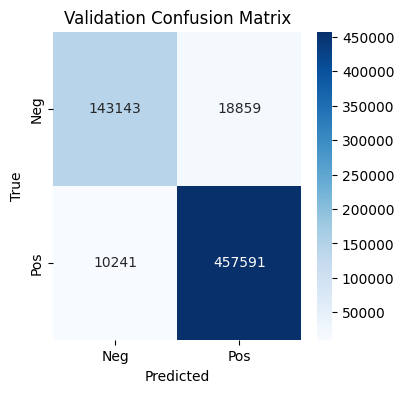

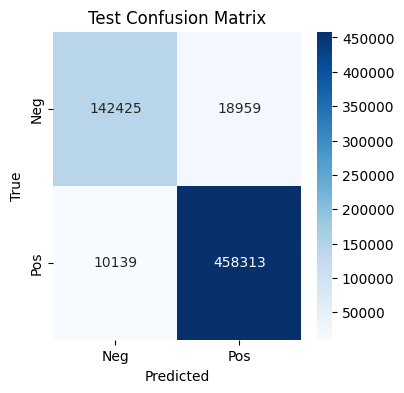

In [ ]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Neg', 'Pos'], yticklabels=['Neg', 'Pos'])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()

plot_confusion_matrix(y_val, clf.predict(X_val), "Validation Confusion Matrix")
plot_confusion_matrix(y_test, clf.predict(X_test), "Test Confusion Matrix")

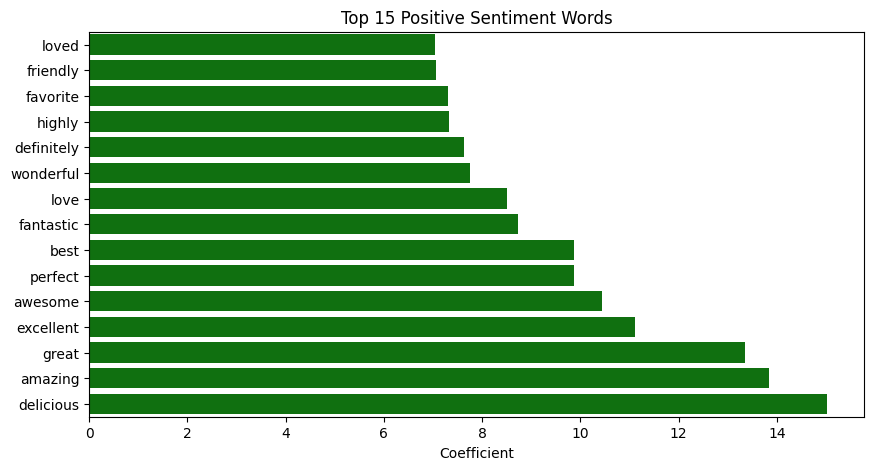

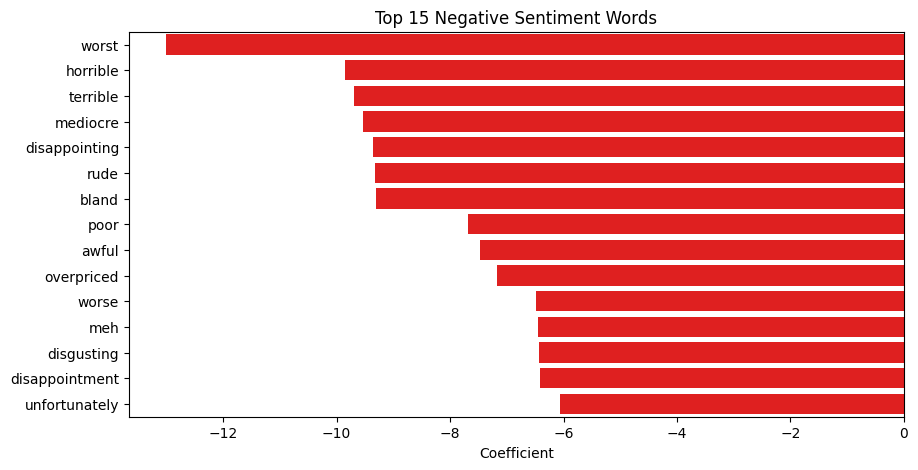

In [7]:
# Get feature names and coefficients
feature_names = vectorizer.get_feature_names_out()
coefs = clf.coef_.flatten()

# Top 15 positive and negative
top_pos = np.argsort(coefs)[-15:]
top_neg = np.argsort(coefs)[:15]

#Plot frequencies for top 15 negative and positive sentiment words
plt.figure(figsize=(10, 5))
sns.barplot(x=coefs[top_pos], y=[feature_names[i] for i in top_pos], color='green')
plt.title("Top 15 Positive Sentiment Words")
plt.xlabel("Coefficient")
plt.show()

plt.figure(figsize=(10, 5))
sns.barplot(x=coefs[top_neg], y=[feature_names[i] for i in top_neg], color='red')
plt.title("Top 15 Negative Sentiment Words")
plt.xlabel("Coefficient")
plt.show()